# Write and load images

Writing, loading and displaying images are necessary components of the scientific python toolbox for microscopy. In this notebook, we just present some aspects of `jupyter notebooks`, before playing around with images. 

This notebook is a simple (?) introduction, it helps getting into the flow and maybe learning about some new tools. You can come back later to it if you don't manager to finish on time.

**Important**: In this notebook, the exercises are indicated by comments blocks and `....`. You will have to write code instead of the `....`. In general, the answers should be simple and are sometimes very close to other lines of code that you ran in previous cells.

## 0 - The first cell

Click on the first cell with code and press `shift+enter` to run a single cell. You have more options and shortcuts in the `Edit` and `Cell` menus.

In [1]:
def decode(s):
    '''
    Decode hexadecimal messages.
    '''
    return bytes.fromhex(s)

In [2]:
message = "4C 65 74 27 73 20 73 74 61 72 74 21"

print(decode(message))

b"Let's start!"


## 1 - Creating an image with numpy

In this first real python exercise, we are going to create a `numpy` array representing a 3D stack and learn how to show it in the `jupyter notebook`. Run the first cell to add the function definition to the current session.

In [3]:
import numpy as np

# You don't have to understand the function to continue
def get_3D_gaussian(delta_z, size_xy=255, std_xy=20., std_z=3., a0=255):    
    '''
    Return a 2D Gaussian whose standard deviation and amplitude depend on the 
    distance to the central plane z=0.
    
    Basically some sort of PSF.

            Parameters:
                    size_xy (int): Size of the slice in X and Y directions
                    delta_z (int): Distance of the slice to the center (positive 
                                   or negative)
                    a0 (int): Maximum amplitude of the Gaussian. 
                    std_xy (float): Standard deviation in pixels of the Gaussian 
                                    in the X and Y directions.
                    std_z (float): Standard deviation in pixels of the Gaussian 
                                   amplitude in the Z direction.

            Returns:
                    XY slice
    '''
    
    # let's create a grid of values: n+1 values ranging from 0 to n
    n = size_xy
    grid = np.linspace(0, n, n+1)
    
    # create a meshgrid
    x, y = np.meshgrid(grid, grid)
    
    # distance to the center of the grid
    delta_x = x - size_xy / 2
    delta_y = y - size_xy / 2
    d_xy = np.sqrt(delta_x*delta_x+delta_y*delta_y)
    
    # effective standard deviation (small at z=0, larger with distance to the center plane)
    # with a symmetry break between +z and -z
    std_xy_eff = std_xy * ( abs(delta_z) + 0.5)
        
    # compute Gaussian in XY
    xy_gauss = np.exp(-( d_xy**2 / (2.0 * std_xy_eff**2 ) ) )
    
    # compute a z-dependent amplitude term
    amplitude = a0 * np.exp(-( delta_z**2 / (2.0 * std_z**2 ) ) )
    
    # return the image with integer values
    return (xy_gauss * amplitude).astype(np.int16)

Let's now call this function to get a single slice:

In [4]:
#######################################################
##### exercise: call the get_3D_gaussian function #####

single_img = get_3D_gaussian(5)  # we only pass one argument 

# print a sub-array of the image (read about calling numpy subarrays if you are not sure)
print(single_img[0:4])  # hopefully, it is not just zeroes

[[16 16 16 ... 16 16 16]
 [16 16 17 ... 17 16 16]
 [16 17 17 ... 17 17 16]
 [17 17 17 ... 17 17 17]]


Plotting numbers is not the best way to visualize numpy arrays. We can use `matplotlib` to see the array as an **image**. 

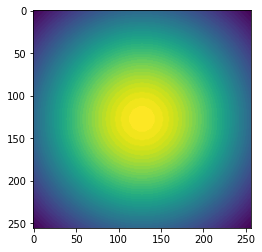

In [5]:
import matplotlib.pyplot as plt

######################################################
##### exercise: plot single_img using plt.imshow #####
fig, ax = plt.subplots()
ax.imshow(single_img)

Often we need to deal with multidimensional images, and since the `get_3D_gaussian` function output is z-dependent, let's create a **stack** with different z-slices.

In [6]:
###############################################
##### exercise: generate a list of images #####
#####                                     #####
##### hint: look at line 27 in function   #####
#####       get_3D_gaussian (see above)   #####

# let's create a grid of points
dzs = np.linspace(-5, 5, 11)

# now generate a list of images by calling the function get_3D_gaussian
imgs = [get_3D_gaussian(d) for d in dzs]

In [7]:
imgs

[array([[16, 16, 16, ..., 16, 16, 16],
        [16, 16, 17, ..., 17, 16, 16],
        [16, 17, 17, ..., 17, 17, 16],
        ...,
        [16, 17, 17, ..., 17, 17, 16],
        [16, 16, 17, ..., 17, 16, 16],
        [16, 16, 16, ..., 16, 16, 16]], dtype=int16),
 array([[14, 14, 14, ..., 14, 14, 14],
        [14, 14, 14, ..., 14, 14, 14],
        [14, 14, 14, ..., 14, 14, 14],
        ...,
        [14, 14, 14, ..., 14, 14, 14],
        [14, 14, 14, ..., 14, 14, 14],
        [14, 14, 14, ..., 14, 14, 14]], dtype=int16),
 array([[5, 5, 5, ..., 5, 5, 5],
        [5, 5, 6, ..., 6, 5, 5],
        [5, 6, 6, ..., 6, 6, 5],
        ...,
        [5, 6, 6, ..., 6, 6, 5],
        [5, 5, 6, ..., 6, 5, 5],
        [5, 5, 5, ..., 5, 5, 5]], dtype=int16),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int16),
 array([[0, 0, 0, ..., 0

Here is a more complicated function to plot images. Since we have a list of images, we would like to be able to compare them side by side.

In [8]:
def plot_images_list(images, titles=None, max_value=255):
    '''
    Plot a list of images.

            Parameters:
                    images (list): List of 2D numpy arrays
                    titles (list): List of string used as titles for the subplots
                    max_value (float): Maximum amplitude of the Gaussian.
    '''
    
    # some flexible parameters to adapt the number of rows/cols and size
    root = np.sqrt( len( images ) ).astype(int)
    size = 50 / root  # arbitrary

    # if no title was given
    if titles is None:
        titles = [i for i in range( len(images) )]
    
    # create subplots
    fig, axs = plt.subplots(root, root, figsize=(10, 10))
    
    # now we populate the subplots with images
    for i, ax in enumerate(axs.flatten()):
        
        if i < len(imgs):
            # show image
            ax.imshow(imgs[i], vmin=0, vmax=max_value)
            
            # add title
            ax.set_title(titles[i])
        else:
            # in case the number of suplots is larger than the number of elements in images
            ax.remove()
    plt.show()


Let's use the previous function to plot all the slices.

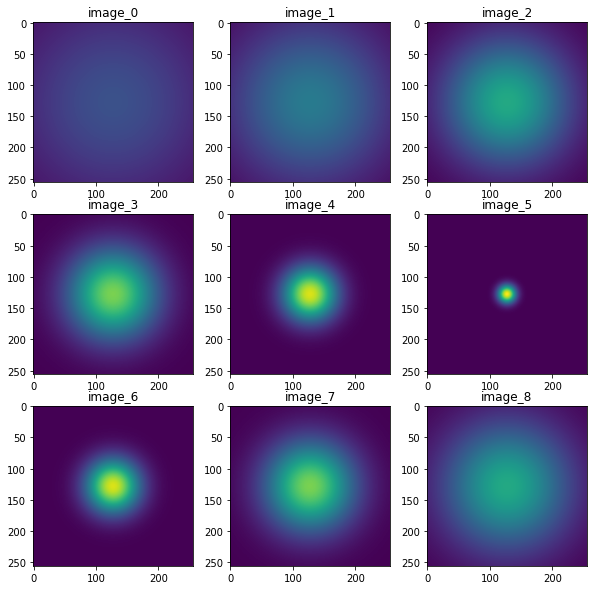

In [9]:
###########################################################
##### exercise: plot each image in the list           #####
#####   - generate meaningful titles for each subplot #####
#####   - use plot_images_list to plot the images     #####

# make titles to use on top of each frame 
titles = ["image_"+str(i) for i,z in enumerate(dzs)]

# use plot_images_list to plot multiple images
plot_images_list(imgs, titles=titles)

###########################################################
##### Question: the images can be compared because they are
##### plotted with a fixed contrast. Can you see where this
##### happens?

Now, let's create a real stack instead of a list of images.

In [10]:
###############################################################
##### exercise: create a single numpy array from the list #####
#####                                                     #####
##### hint: search how to stack arrays of same dimension  ##### 

stack = np.stack(imgs)

# print the shape of the stack to verify that it was stacked correctly
print(f'Shape of the stack: {stack.shape}')

Shape of the stack: (11, 256, 256)


In [11]:
stack

array([[[16, 16, 16, ..., 16, 16, 16],
        [16, 16, 17, ..., 17, 16, 16],
        [16, 17, 17, ..., 17, 17, 16],
        ...,
        [16, 17, 17, ..., 17, 17, 16],
        [16, 16, 17, ..., 17, 16, 16],
        [16, 16, 16, ..., 16, 16, 16]],

       [[14, 14, 14, ..., 14, 14, 14],
        [14, 14, 14, ..., 14, 14, 14],
        [14, 14, 14, ..., 14, 14, 14],
        ...,
        [14, 14, 14, ..., 14, 14, 14],
        [14, 14, 14, ..., 14, 14, 14],
        [14, 14, 14, ..., 14, 14, 14]],

       [[ 5,  5,  5, ...,  5,  5,  5],
        [ 5,  5,  6, ...,  6,  5,  5],
        [ 5,  6,  6, ...,  6,  6,  5],
        ...,
        [ 5,  6,  6, ...,  6,  6,  5],
        [ 5,  5,  6, ...,  6,  5,  5],
        [ 5,  5,  5, ...,  5,  5,  5]],

       ...,

       [[ 5,  5,  5, ...,  5,  5,  5],
        [ 5,  5,  6, ...,  6,  5,  5],
        [ 5,  6,  6, ...,  6,  6,  5],
        ...,
        [ 5,  6,  6, ...,  6,  6,  5],
        [ 5,  5,  6, ...,  6,  5,  5],
        [ 5,  5,  5, ...,  5,  5

Often, we like to look at max projections to get a sense of the objects.

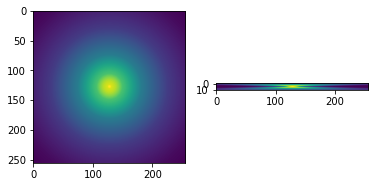

In [13]:
###############################################################
##### exercise: use numpy to compute a max projection of  #####
#####           the stack along one dimension             #####

max_projection_0 = np.max(stack, axis=0)
max_projection_1 = np.max(stack, axis=1)

# plot the projection (hint: we've seen how to plot a single frame before)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(max_projection_0)
ax2.imshow(max_projection_1)

# Try now with other axes!

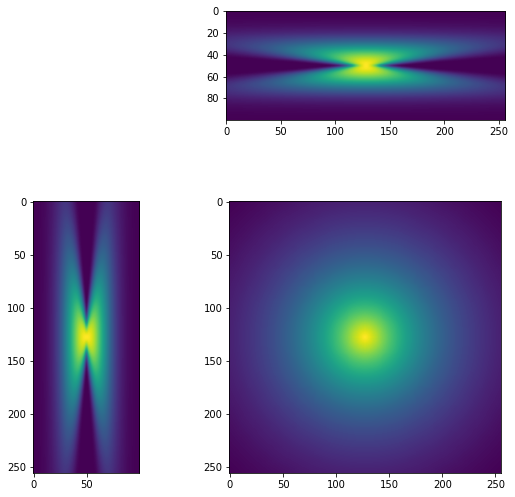

In [14]:
#############################################################################
##### Bonus: let's use a finer z grid and plot all projections together #####
#####                                                                   #####
##### This cell just shows you one way of plotting the projections in   #####
##### along each dimension together                                     #####

# finer grid
dzs = np.linspace(-10, 10, 100)

# new stack from the list
new_stack = np.stack([get_3D_gaussian(d) for d in dzs])

# get max projections
max_proj_x = np.max(new_stack, axis=2)
max_proj_y = np.max(new_stack, axis=1)
max_proj_z = np.max(new_stack, axis=0)

# create sub-plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

ax1.remove()
ax2.imshow(max_proj_x)
ax3.imshow(max_proj_y.T)
ax4.imshow(max_proj_z)
plt.subplots_adjust(wspace=0, hspace=0)  # remove some white space

## 2 - Saving and loading a numpy array

The most convenient way to save a `numpy` array is simply to use the save and load function from `numpy`.

In [ ]:
import os
from pathlib import Path

# create a data directory
data = 'Data'
if not Path(data).exists():
    os.mkdir('Data')

# save the image
path = os.path.join(data, 'my_stack.npy')
np.save(path, stack)

# check that it was written to the disk
assert Path(path).exists(), 'Error: the path does not exists!'

##################################################
##### exercise: load the stack using np.load #####

# load the stack
loaded_stack = ....

# check that they are the same (we compare each value in the arrays)
# if no error is thrown (because assert passed), then they are the same!
assert (loaded_stack == stack).all(), 'Error: the two stacks are not the same!'

# or you might want to have Python tell you also in the case where the two stacks are the same
print(f'Are the two stacks identical? {(loaded_stack == stack).all()}')

## 3 - Saving and loading tiffs

While `.npy` are convenient, they are not typically read by other software or languages. For instance, they would not be convenient to open in ImageJ2/Fiji or add to a presentation. Tiffs are a popular format because they allow multi-dimensional images, extensive metadata and are usually not (lossy) compressed.

There are many packages to load and save tiffs in Python. We do not have time to review them all, but the differences will be whether they allow multidimensional images or reading/writing metadata. Also interesting are packages that can load other image formats.

Here is a (non-exhausitve) list of packages used to load tiffs (and other formats):
- [tifffile](https://pypi.org/project/tifffile/)
- [skimage](https://scikit-image.org/docs/dev/api/skimage.io.html#skimage.io.imread) (scikit-image)
- [aicsimageio](https://allencellmodeling.github.io/aicsimageio/) 
- [python-bioformats](https://pythonhosted.org/python-bioformats/)
- [pyimagej](https://pyimagej.readthedocs.io/en/latest/) 
- [pillow (PIL)](https://pypi.org/project/Pillow/)

For simplicity we will use `tifffile` here. `tifffile` allows reading/writing multidimensional arrays and metada (to some extent).

In [ ]:
from tifffile import imwrite

#################################################
##### exercise: save the stack as a tiff    #####
#####                                       #####
##### hint: look at the line 1 in this cell #####

# create path
path = os.path.join(data, 'my_stack.tif')

# save the stack
....(path, stack)

# check if the image has been created on the disk (hint: see previous cell line 14)
....

In [ ]:
from tifffile import imread

#####################################################
##### exercise: read the stack and plot a slice #####

# load stack
loaded_tiff = ....

# check that it is the same as the stack (hint: see two cells above, live 24)
....

# does that mean that tiffile returns a numpy array? Print the type of loaded_tiff:
print(f'Type of the object returned by tiffile: {....(loaded_tiff)}')

# plot a single slice
....

In [ ]:
##################################################
##### exercise: save the slices individually #####

for i in range(stack.shape[0]):
    # create path
    path = os.path.join(data, ....)  # create a name that depends on i
    
    # write the corresponding slice to the disk
    ....

## 4 - Other ways to plot

While `matplotlib` is the most common ways of visualizing numpy arrays and images, other alternatives have emerged (beyond `jupyter notebooks`). 


### napari

One that should be mentioned is `napari`, which is a N-dimensional image visualization tool. [napari](https://napari.org/) is a full software through which you can install plugins (among which the algorithms that you will use during this course). To a certain extent, `napari` can be used within `jupyter notebooks`. The most common way to use `napari` is to simply start it from the console.

<img src="https://napari.org/_images/launch_cli_image.png" width="800" alt="napari"/>


### itkwidgets


Another way, that is specifically integrated with `jupyter notebooks`, is `itkwidgets`.

Now...

...

...


... prepare your mind to be blown away. Run the next cell:

In [15]:
from itkwidgets import view
from scipy import ndimage

# Your stack (probably) has a smaller z than x and y, which will lead in 3D to a very squished stack. 
# Let's pretend we know the pixel size and resize the stack:
pixel_size = (1, 0.1, 0.1)  # (z, x, y)
real_stack = ndimage.zoom(stack, pixel_size, order=0)

# It might take a while
view(real_stack, rotate=True, axes=True, gradient_opacity=0.9)

# Play around a bit with the viewer!

Viewer(axes=True, geometries=[], gradient_opacity=0.9, point_sets=[], rendered_image=<itk.itkImagePython.itkIm…

That's it for now!